# PSO para otimizar pesos de MLP 

In [1]:
using Distributions
using CSV
using Plots
using DataFrames
using Random

In [2]:
Random.seed!(123);

### MLP

In [3]:
function init_params(n_in::Int64, n_h::Int64)
    W1 = rand(Uniform(-1/sqrt(n_h+n_in),1/sqrt(n_h+n_in)),n_h, n_in)
    b1 = rand(Uniform(-1/sqrt(n_h),1/sqrt(n_h)),n_h)
    W2 = rand(Uniform(-1/sqrt(1+n_h),1/sqrt(1+n_h)), 1, n_h)
    b2 = rand(Uniform(-1,1), 1, 1)
    return [W1, b1, W2, b2]
end

function forward_prop(x, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]
    
    linear1 = W1 * x .+ b1
    linear2 = W2 * linear1 .+ b2
    out = 1.7159*tanh.(2/3*linear2)
    
    return out
end

function compute_cost(A2, y)
    m = size(y)[2]
    erro = A2 .- y
    cost = 1/m * sum(erro.^2)
    return cost
end

function params_array(params)
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    lista_params = hcat(reshape(W1, 1,prod(size(W1))), reshape(b1, 1,prod(size(b1))), 
        reshape(W2, 1,prod(size(W2))), reshape(b2, 1,prod(size(b2))))
    return lista_params
end

function params_reshape(lista_params, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]

    w1_dim_tot = prod(size(W1))
    b1_dim_tot = prod(size(b1))
    w2_dim_tot = prod(size(W2))
    b2_dim_tot = prod(size(b2))

    W1_reshaped = reshape(lista_params[1:w1_dim_tot], size(W1))
    id = w1_dim_tot
    b1_reshaped = reshape(lista_params[id+1:id+b1_dim_tot], size(b1))
    id += b1_dim_tot
    W2_reshaped = reshape(lista_params[id+1:id+w2_dim_tot], size(W2))
    id += w2_dim_tot
    b2_reshaped = reshape(lista_params[id+1:id+b2_dim_tot], size(b2))
    
    return [W1_reshaped, b1_reshaped, W2_reshaped, b2_reshaped]
    
end


params_reshape (generic function with 1 method)

### Importar dados

In [4]:
sunspot = CSV.read("dados/sunspot.csv"; delim=",")
sunspot_serie = sunspot["valor"];

In [5]:
sunspot_serie[1:10]

10-element Array{Float64,1}:
  5.0
 11.0
 16.0
 23.0
 36.0
 58.0
 29.0
 20.0
 10.0
  8.0

### Funções de normalização

In [6]:
# normalizar serie
function normalizar(serie)
    max = maximum(serie)
    min = minimum(serie)
    
    y_temp = 2 .* ((serie .- min)) ./ (max .- min) .- 1
    
    y = y_temp ./ sqrt(size(serie)[1])
    
    return y
end

function desnormalizar(serie_norm, serie)
    max = maximum(serie)
    min = maximum(serie)
    
    serie_temp = serie_norm .* sqrt(size(serie)[1])
    serie_temp2 = (serie_temp .+ 1)/2
    serie_temp3 = serie_temp2 * ((max - min) + min)
    return serie_temp3 
end

desnormalizar (generic function with 1 method)

In [7]:
function split_sequence(serie, n_steps_in::Int64)
    len = size(serie)[1]
    max_iter = len - n_steps_in
    seq_x = zeros(max_iter, n_steps_in)
    seq_y = zeros(max_iter)
    for i in 1:len-n_steps_in
        idx = i + n_steps_in - 1
        out_idx = idx + 1
        if out_idx > len
            println(i)
            println("len = ", len)
            println("out_idx = ", out_idx)
            println("Out_idx > len")
            break
        end
        seq_x[i,:] = serie[i:idx]
        seq_y[i] = serie[out_idx]
    end
    return seq_x, seq_y
end

split_sequence (generic function with 1 method)

### Função de split treino/val/teste

In [8]:
function divisao_dados_temporais(X, y, perc_treino::Float64, perc_val::Float64)
    tam_treino = convert(Int64, floor(perc_treino * size(y)[1]))
    
    if perc_val > 0
        tam_val = convert(Int64, floor(perc_val * size(y)[1]))
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_val = X[tam_treino+1:tam_treino+1+tam_val,:]
        y_val = y[tam_treino+1:tam_treino+1+tam_val]
        
        X_teste = X[(tam_treino+tam_val+1):end,:]
        y_teste = y[(tam_treino+tam_val+1):end]
        
        return X_treino, y_treino, X_teste, y_teste,  X_val, y_val
        
    else
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_teste = X[tam_treino+1:end,:]
        y_teste = y[tam_treino+1:end]
        return X_treino, y_treino, X_teste, y_teste
    end
end

divisao_dados_temporais (generic function with 1 method)

### Função do PSO

In [101]:
function PSO(X, y, params, n_particles::Int64, dim, max_iter::Int64, LB::Float64, UB::Float64, perc_treino::Float64, perc_val::Float64)
    
    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)
    
    particles = rand(n_particles, sum(dim))
    velocity = zeros(n_particles, sum(dim))
    pbest = particles
    gbest = pbest[1,:]
    
    parametros = params_reshape(gbest, params)
    y_pred = forward_prop(X[:,:,1]', parametros)
    gbest_value = compute_cost(y_pred, y[:,1]')    

    fitness_value = zeros(n_particles)

    for i in eachindex(fitness_value)
        parametros = params_reshape(particles[i,:], params)
        y_pred = forward_prop(X[:,:,1]', parametros)
        fitness_value[i] = compute_cost(y_pred, y[:,1]')
    end
    
    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5
    
    iteracao = 1
    for janela in 1:size(y)[2]
        
        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:,janela], y[:,janela], perc_treino, perc_val)
        
        X_tv = vcat(X_treino, X_val)'
        Y_tv = vcat(Y_treino, Y_val)'

        for k in 1:max_iter
            w=wmax-(wmax-wmin)*k/max_iter
        

            for i in 1:n_particles
                for j in 1:sum(dim)
                    velocity[i, j] = w*velocity[i,j] + c1*rand()*(pbest[i,j] - particles[i,j]) + c2*rand()*(gbest[j] - particles[i,j])
                end
            end

            # update pso position
            for i in 1:n_particles
                for j in 1:sum(dim)
                    particles[i,j] = particles[i,j] + velocity[i,j]
                end
            end

            # handling boundary violations 
            for i in 1:n_particles
                for j in 1:sum(dim)
                    if particles[i,j]<LB 
                        particles[i,j]=LB 
                    elseif particles[i,j]>UB 
                        particles[i,j]=UB 
                    end
                end 
            end 

            # evaluating fitness
            for i in 1:n_particles
                parametros = params_reshape(particles[i,:], params)
                y_pred = forward_prop(X_treino', parametros)
                fitness_value[i] = compute_cost(y_pred, Y_treino')
            end

            # updating pbest and fitness
            for i in 1:n_particles
                parametros_pbest = params_reshape(pbest[i, :], params)
                y_pred_pbest = forward_prop(X_treino', parametros_pbest)
                if fitness_value[i] < compute_cost(y_pred_pbest, Y_treino')
                    pbest[i] = particles[i, :]
                end
            end

            # updating gbest 
            for i in 1:n_particles    
                if fitness_value[i] < gbest_value
                    gbest_value = fitness_value[i]
                    gbest = particles[i,:]   
                end
            end
    
            parametros_gbest = params_reshape(gbest, params)
            # treino e validacao mse
            A2_gbest_tv = forward_prop(X_tv, parametros_gbest)
            mse_tv = compute_cost(A2_gbest_tv, Y_tv)
            mse_treino[iteracao] = mse_tv
            #append!(mse_treino,mse_tv)

            # validacao mse
            A2_gbest_v = forward_prop(X_val', parametros_gbest)
            mse_v = compute_cost(A2_gbest_v, Y_val')
            mse_val[iteracao] = mse_v
            #append!(mse_val,mse_v)

            # teste
            A2_gbest_t = forward_prop(X_teste', parametros_gbest)
            mse_t = compute_cost(A2_gbest_t, Y_teste')
            mse_teste[iteracao] = mse_t
            #append!(mse_teste,mse_t)
            
            iteracao += 1
        end
    end
    return mse_treino, mse_val, mse_teste
end

PSO (generic function with 1 method)

In [10]:
function n_model_pso(X, y, n_h::Int64, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64)
    n_in = size(X)[2]
    parametros = init_params(n_in, n_h)
    
#     A2 = forward_prop(X', parametros)

#     best_cost = compute_cost(A2, y')
    
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    
    dim_list = [prod(size(W1)), prod(size(b1)), prod(size(W2)), prod(size(b2))]
    
    qtd_particulas_dim = convert(Int64,(size(W1)[2] + 1) * size(W1)[1] + (size(W1)[1] + 1)* size(W2)[1])

    mse_treino, mse_val, mse_teste = PSO(X, y, parametros, qtd_particulas_dim, dim_list, num_iteracoes, -1.0, 1.0, perc_treino, perc_val)
        
    return mse_treino, mse_val, mse_teste
end

n_model_pso (generic function with 1 method)

### Função para criar os cenários dinâmicos

In [11]:
# janelamento para cenários dinâmicos
function cenarios_dinamicos(serie, window_size::Int64, step_size::Int64)
    
    if ndims(serie) == 1
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1)]

        cenarios = zeros(0)

        append!(cenarios, s_temp)

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1)]
            cenarios = hcat(cenarios, s_temp)
        end
        return cenarios
    else
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1), :]

        cenarios = zeros(w, size(serie)[2], i_max)

        cenarios[:,:, 1] = s_temp

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1),:]
            cenarios[:, :, i] = s_temp
        end
        return cenarios
    end
end

cenarios_dinamicos (generic function with 1 method)

### Função para executar os cenários dinâmicos

In [12]:
# Criando cenários
function cenarios_execucoes_pso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    neuronios = 2:25
    
    mse_treino = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
        
        # Neuronios
        for (j,z) in zip(neuronios, eachindex(neuronios))
            
            println("Neurônios: ", j)
            
            mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = n_model_pso(X_I, y_I, j, f, perc_treino, perc_val)

            # salvar lista com os mse de treino para todas as iterações
            mse_treino[execucao, z,:] = mse_treino_lista_temp
            # salvar lista com os mse de validacao para todas as iteracoes
            mse_val[execucao, z,:] = mse_val_lista_temp
            # salvar lista com os mse de teste para todas as iterações
            mse_teste[execucao, z,:] = mse_teste_lista_temp

        end
    end
    return mse_treino, mse_val, mse_teste
end
            

cenarios_execucoes_pso (generic function with 1 method)

In [13]:
function avaliacao_resultados(mse_treino_cenarios, mse_val_cenarios, mse_teste_cenarios, f, quantidade_janelas, execucoes)
    
    mse_treino = Array{Float64, 2}(undef, execucoes, quantidade_janelas*f)
    #zeros(execucoes, quantidade_janelas*f)
    mse_teste = Array{Float64, 2}(undef, execucoes, quantidade_janelas*f)
    #zeros(execucoes, quantidade_janelas*f)
    
    for ex in 1:execucoes
        id_neuronios = Array{Int64, 1}(undef, quantidade_janelas)
        for janela in 1:quantidade_janelas
            id_neuronios[janela] = findmin(mse_val_cenarios[ex, :, f*janela])[2]
        end
        mse_treino[ex, 1:f] = mse_treino_cenarios[ex, id_neuronios[1], 1:f]
        mse_teste[ex, 1:f] = mse_teste_cenarios[ex, id_neuronios[1], 1:f]
        
        for jan in 1:quantidade_janelas
            if jan == quantidade_janelas
                mse_treino[ex, f*jan-f+1:f*jan] = mse_treino_cenarios[ex, id_neuronios[jan], f*jan-f+1:f*jan]
                mse_teste[ex, f*jan-f+1:f*jan] = mse_teste_cenarios[ex, id_neuronios[jan], f*jan-f+1:f*jan]
            else
                mse_treino[ex, f*jan+1:f*jan+f] = mse_treino_cenarios[ex, id_neuronios[jan], f*jan+1:f*jan+f]
                mse_teste[ex, f*jan+1:f*jan+f] = mse_teste_cenarios[ex, id_neuronios[jan], f*jan+1:f*jan+f]
            end
        end
    end
        
    qtd_iteracoes = size(mse_treino)[2]
    
    te = sum(mse_treino, dims = 2)./qtd_iteracoes
    ge = sum(mse_teste, dims = 2)./qtd_iteracoes

    gf = ge./te

    te_medio = mean(te)
    te_std = std(te)

    ge_medio = mean(ge)
    ge_std = std(ge)

    gf_medio = mean(gf)
    gf_std = std(ge)

    println("Te médio: ", te_medio)
    println("TE desvio: ", te_std)
    println("GE medio: ", ge_medio)
    println("GE desvio: ", ge_std)
    println("GF medio: ", gf_medio)
    println("GF desvio: ", gf_std)

    resultados = [te_medio, te_std, ge_medio, ge_std, gf_medio, gf_std]

    return resultados, mse_treino, mse_teste

end  

avaliacao_resultados (generic function with 1 method)

In [14]:
serie_norm = normalizar(sunspot_serie)
se = desnormalizar(serie_norm, sunspot_serie);

### Função de dividir os dados em X e Y

In [15]:
X, y = split_sequence(serie_norm, 10);

In [16]:
w = 60
s = 60
f = 100
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

3

## Teste do PSO para Sunspot - Cenário 4 - 10 neurônios na camada escondida

In [17]:
mse_treino, mse_val, mse_teste = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

Quantidade de iterações: 300
Execução: 1
Neurônios: 2
Neurônios: 3
Neurônios: 4
Neurônios: 5
Neurônios: 6
Neurônios: 7
Neurônios: 8
Neurônios: 9
Neurônios: 10
Neurônios: 11
Neurônios: 12
Neurônios: 13
Neurônios: 14
Neurônios: 15


LoadError: InterruptException:

In [18]:
resultados, mse_treino_r, mse_teste_r = avaliacao_resultados(mse_treino, mse_val, mse_teste, f, quantidade_janelas, 3);

LoadError: UndefVarError: mse_treino not defined

In [19]:
plot(mean(mse_treino_r, dims = 1)', label = "Treino", title = "PSO treinamento vs teste")
plot!(mean(mse_teste_r, dims = 1)', label = "Teste")

LoadError: UndefVarError: mse_treino_r not defined

## Testando CQSO

In [36]:
sunspot = CSV.read("dados/sunspot.csv"; delim=",")
sunspot_serie = sunspot["valor"]
serie_norm = normalizar(sunspot_serie)
se = desnormalizar(serie_norm, sunspot_serie)
X, y = split_sequence(serie_norm, 10);

In [37]:
w = 60
s = 10
f = 50
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

21

In [38]:
parameters = init_params(10, 10)
W1 = parameters[1]
b1 = parameters[2]
W2 = parameters[3]
b2 = parameters[4]

1×1 Array{Float64,2}:
 0.8169972239275416

In [39]:
X_I = cenarios_dinamicos(X, w, s)
y_I = cenarios_dinamicos(y, w, s);

In [40]:
size(y_I)[2]*f

1050

In [41]:
T = convert(Int64,floor(f/s*(size(y)[1]-w)+f))

1145

In [42]:
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))
println("Quantidade de janelas: ", quantidade_janelas)
println("Quantidade de iterações totais: ", quantidade_janelas * f)

Quantidade de janelas: 21
Quantidade de iterações totais: 1050


## CQSO 


In [91]:
function CQSO(X, y, params, n_particles::Int64, dim, max_iter::Int64, LB::Float64, UB::Float64, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)

    n = sum(dim)
    a = zeros(Int64, n)

    #a = Int64[]

    for i in 2:n
        if n%i == 0
            #push!(a, i)
            a[i] = i
        end
    end

    n_sub_swarms = sort(a[a.!=0])[1]

    # divide the dimensions per subswarm
    num = n
    div = n_sub_swarms

    dimensions_list = zeros(Int64, div)

    for x in 1:div
            if x < num % div
                dimensions_list[x] = 1 + (num ÷ div)
            else
                dimensions_list[x] = 0 + (num ÷ div)
            end
    end

    #context_vector = zeros(n_sub_swarms, n_sub_swarms)
    context_vector = zeros(n_sub_swarms, n)
    
    
    # Create a multiswarm and his velocities
    #multi_swarm_vector = zeros(n_sub_swarms, n_particles, dimensions_list[1])
    multi_swarm_vector = zeros(n_sub_swarms, n_particles, n)
    #velocity_vector = zeros(n_sub_swarms, n_particles, dimensions_list[1])
    velocity_vector = zeros(n_sub_swarms, n_particles, n)
    
    for i_subswarm in 1:n_sub_swarms
        #context_vector[i_subswarm, :] = rand(Uniform(-1.0, 1.0), n_sub_swarms)
        context_vector[i_subswarm, :] = rand(Uniform(-1.0, 1.0), n)
        for i_particle in 1:n_particles
            #multi_swarm_vector[i_subswarm, i_particle,:] = rand(Uniform(-1.0, 1.0), dimensions_list[1])
            multi_swarm_vector[i_subswarm, i_particle, :] = rand(Uniform(-1.0, 1.0), n)
        end
    end

    gbest = copy(multi_swarm_vector[1,1,:])
    pbest = copy(multi_swarm_vector[1,1,:])

    #sub_swarm_pbest = copy(context_vector)
    sub_swarm_pbest = copy(context_vector[1,:])
    parameters = copy(params)

    #parametros = params_reshape(reshape(context_vector, n), parameters)
    parametros = params_reshape(sub_swarm_pbest, parameters)
    
    y_pred = forward_prop(X[:,:,1]', parametros)
    gbest_value = compute_cost(y_pred, y[:, 1]')
    pbest_value = copy(gbest_value)

    parametros_gbest = copy(parametros)

    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5

    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)

    it_idx = 1
    
    println("Quantidade total de iter: ", size(mse_treino))

    for janela in 1:size(y)[2]
    

        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:, janela], y[:, janela], perc_treino, perc_val)

        X_tv = vcat(X_treino, X_val)'
        Y_tv = vcat(Y_treino, Y_val)'

        # Iterações
        # Para cada sub_swarm em multi_swarm_vector
        iteration = 1
        while iteration <= max_iter

            w=wmax-(wmax-wmin)*iteration/max_iter

            # for particula in sub_swarm
            for i_sub_swarm in 1:n_sub_swarms

                for i_particle in 1:n_particles

                    # Calcular o fitness 
                    context_copy = copy(context_vector)
                    #conetxt_copy = copy(context_vector[i_sub_swarm,:])

                    particle = copy(multi_swarm_vector[i_sub_swarm,i_particle,:])
                    context_copy[i_sub_swarm, :] = copy(particle)

                    #parameters_temp = params_reshape(reshape(context_copy, n), parameters)
                    #parameters_temp = params_reshape(reshape(context_copy[i_sub_swarm,:], n), parameters)
                    parameters_temp = params_reshape(context_copy[i_sub_swarm, :], parameters)
                    
                    A2_part = forward_prop(X_treino', parameters_temp)
                    fitness_candidate = compute_cost(A2_part, Y_treino')
                    
                    if fitness_candidate < pbest_value
                    # se o fitness da nova particula for melhor, ela vira o pbest
                        pbest = copy(multi_swarm_vector[i_sub_swarm, i_particle, :])
                        pbest_value = copy(fitness_candidate)
                        sub_swarm_pbest = copy(context_copy[i_sub_swarm, :])

                        # feito o pbest devemos atualizar as posições das particulas
                    end

                    if i_particle <= (neutral_p - 1)  

                        # atualiza como PSO vanilla
                        new_velocity = (w*velocity_vector[i_sub_swarm, i_particle, :]) .+ 
                        ((c1 * rand()) * (pbest .- multi_swarm_vector[i_sub_swarm, i_particle, :])) .+
                        ((c2 * rand()) * (gbest .- multi_swarm_vector[i_sub_swarm, i_particle, :]))

                        new_position = new_velocity .+ multi_swarm_vector[i_sub_swarm, i_particle, :]
                        
                    else
                        # atualiza como QSO
                        dist = sqrt(sum((multi_swarm_vector[i_sub_swarm, i_particle, :] .- gbest).^2))
                        #normal = rand(Normal(0,1), dimensions_list[i_sub_swarm])
                        normal = rand(Normal(0, 1), n)
                        #uniform = rand(dimensions_list[i_sub_swarm])
                        uniform = rand(n)
                        left_size_form = rcloud .* normal
                        
                        if dist == 0
                            break

                        end

                        right_size_form = (uniform.^(1/dimensions_list[i_sub_swarm])) ./ dist
                        new_position = left_size_form .* right_size_form
                        
                    end
                    # check if the positions is LB<x<UB
                    for i in eachindex(new_position) 
                                            
                        if new_position[i]<LB 
                            new_position[i]=LB 
                        elseif new_position[i]>UB 
                            new_position[i]=UB 
                        end
                    end 
                    
                    multi_swarm_vector[i_sub_swarm, i_particle, :] = copy(new_position)

                end   

                if pbest_value < gbest_value
                    gbest = copy(pbest)
                    gbest_value = copy(pbest_value)
                    context_vector[i_sub_swarm, :] = copy(sub_swarm_pbest)
                    parametros_gbest = copy(sub_swarm_pbest)
                end
            end
#            parameters_gbest = params_reshape(reshape(context_vector, n), parameters)
            #parameters_gbest = params_reshape(context_vector, parameters)    
        parameters_gbest = params_reshape(parametros_gbest, parameters)

        A2_gbest_tv = forward_prop(X_tv, parameters_gbest)
        mse_tv = compute_cost(A2_gbest_tv, Y_tv)
        mse_treino[it_idx] = mse_tv

        A2_gbest_v = forward_prop(X_val', parameters_gbest)
        mse_v = compute_cost(A2_gbest_v, Y_val')
        mse_val[it_idx] = mse_v

        A2_gbest_t = forward_prop(X_teste', parameters_gbest)
        mse_t = compute_cost(A2_gbest_t, Y_teste')
        mse_teste[it_idx] = mse_t

        iteration += 1

        it_idx += 1
            
        end

    end
    return mse_treino, mse_val, mse_teste   
end

CQSO (generic function with 1 method)

#### Teste do CQSO para Sunspot - 5 neurônios na camada escondida

In [92]:
n_h = 5
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [93]:
Random.seed!(1);

#### PSO vs CQSO

In [94]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5
Iteração: 6
Iteração: 7
Iteração: 8
Iteração: 9
Iteração: 10
Iteração: 11
Iteração: 12
Iteração: 13
Iteração: 14
Iteração: 15
Iteração: 16
Iteração: 17
Iteração: 18
Iteração: 19
Iteração: 20
Iteração: 21
Iteração: 22
Iteração: 23
Iteração: 24
Iteração: 25
Iteração: 26
Iteração: 27
Iteração: 28
Iteração: 29
Iteração: 30
Iteração: 31
Iteração: 32
Iteração: 33
Iteração: 34
Iteração: 35
Iteração: 36
Iteração: 37
Iteração: 38
Iteração: 39
Iteração: 40
Iteração: 41
Iteração: 42
Iteração: 43
Iteração: 44
Iteração: 45
Iteração: 46
Iteração: 47
Iteração: 48
Iteração: 49
Iteração: 50
Iteração: 51
Iteração: 52
Iteração: 53
Iteração: 54
Iteração: 55
Iteração: 56
Iteração: 57
Iteração: 58
Iteração: 59
Iteração: 60
Iteração: 61
Iteração: 62
Iteração: 63
Iteração: 64
Iteração: 65
Iteração: 66
Iteração: 67
Iteração: 68
Iteração: 69
Iteração: 70
Iteração: 71
Iteração: 72
Iteração: 73
Iteração: 74
Iteração: 75
Iteração: 76
Iteração: 77
Iteração

Iteração: 609
Iteração: 610
Iteração: 611
Iteração: 612
Iteração: 613
Iteração: 614
Iteração: 615
Iteração: 616
Iteração: 617
Iteração: 618
Iteração: 619
Iteração: 620
Iteração: 621
Iteração: 622
Iteração: 623
Iteração: 624
Iteração: 625
Iteração: 626
Iteração: 627
Iteração: 628
Iteração: 629
Iteração: 630
Iteração: 631
Iteração: 632
Iteração: 633
Iteração: 634
Iteração: 635
Iteração: 636
Iteração: 637
Iteração: 638
Iteração: 639
Iteração: 640
Iteração: 641
Iteração: 642
Iteração: 643
Iteração: 644
Iteração: 645
Iteração: 646
Iteração: 647
Iteração: 648
Iteração: 649
Iteração: 650
Iteração: 651
Iteração: 652
Iteração: 653
Iteração: 654
Iteração: 655
Iteração: 656
Iteração: 657
Iteração: 658
Iteração: 659
Iteração: 660
Iteração: 661
Iteração: 662
Iteração: 663
Iteração: 664
Iteração: 665
Iteração: 666
Iteração: 667
Iteração: 668
Iteração: 669
Iteração: 670
Iteração: 671
Iteração: 672
Iteração: 673
Iteração: 674
Iteração: 675
Iteração: 676
Iteração: 677
Iteração: 678
Iteração: 679
Iteraç

([0.42730858352583023, 0.03488692385237487, 0.0012954822969252885, 0.0012954822969252885, 0.0012954822969252885, 0.0012954822969252885, 0.0009977607966151656, 0.0002731228467995087, 0.0002731228467995087, 0.0002731228467995087  …  0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745, 0.00023268521384284745], [0.40757714972949693, 0.024119857408026562, 0.0010917563169518553, 0.0010917563169518553, 0.0010917563169518553, 0.0010917563169518553, 0.000333615348318115, 0.00019644814108611892, 0.00019644814108611892, 0.00019644814108611892  …  0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072, 0.0004301669520141072], [0.4797144115194245, 0.05698537545336964, 0.0002506229592949383,

In [95]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

Quantidade total de iter: (1050,)
215.936281 seconds (307.78 M allocations: 167.240 GiB, 11.18% gc time)


([0.0003259372912618507, 0.0001660297973278668, 0.0001322176373809587, 0.00013966413924092517, 8.924664520171587e-5, 8.123603541202857e-5, 7.716514219750892e-5, 8.009983038265899e-5, 7.639550076650308e-5, 7.126145336318641e-5  …  0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886, 0.00024532996005139886], [0.00010485237854785768, 0.00010192801962939908, 6.119026610522525e-5, 0.00010188520331959283, 3.3585817069881735e-5, 2.713967742699844e-5, 3.903772037877712e-5, 5.029624591841098e-5, 5.061251289228836e-5, 3.9069386226095405e-5  …  0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376, 0.00048372462615607376], [0.001648277486881996, 0.0006852980430674405, 0.00046546

In [96]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

Média mse treino PSO: 0.0005823810803116787
Média mse teste PSO: 0.0007034129496391085
Média mse treino CQSO: 0.0001438520407178643
Média mse teste CQSO: 0.00021782404033244738


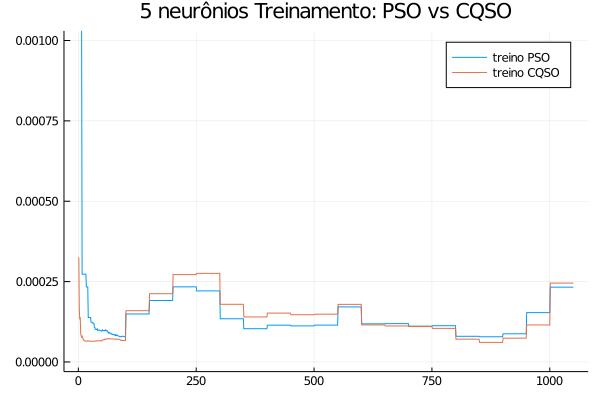

In [97]:
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001], title = "5 neurônios Treinamento: PSO vs CQSO")
plot!(mse_treino_cqso, label= "treino CQSO")

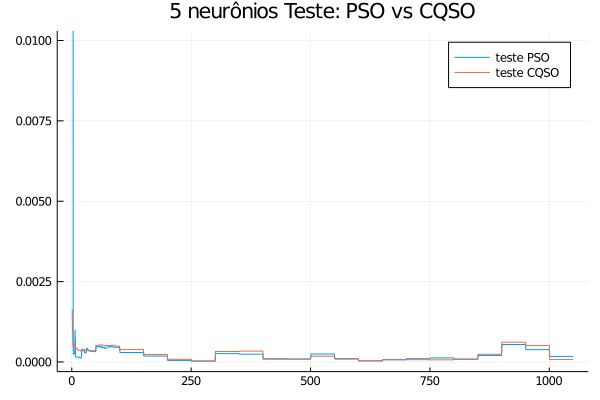

In [98]:
plot(mse_teste_pso, label= "teste PSO", ylims = [0.0, 0.01], title = "5 neurônios Teste: PSO vs CQSO")
plot!(mse_teste_cqso, label= "teste CQSO")

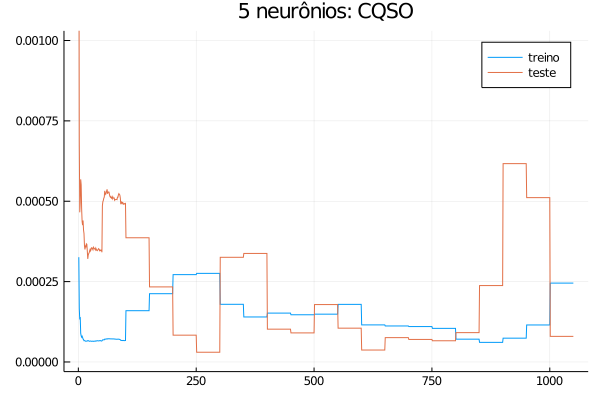

In [99]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.001], title = "5 neurônios: CQSO")
plot!(mse_teste_cqso, label = "teste")

### Testando com 10 neuronios

In [102]:
n_h = 10
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [103]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

  9.971155 seconds (16.80 M allocations: 2.979 GiB, 7.46% gc time)


([1.9898609588889127, 0.3966307616188121, 0.0027487036720782176, 0.0027487036720782176, 0.0027487036720782176, 0.0014082513380586064, 0.0010536437808180861, 0.0010536437808180861, 0.0008432371476389732, 0.0008432371476389732  …  0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147, 0.0006220811764570147], [1.9599563831301459, 0.3794966725873645, 0.001514192154687581, 0.001514192154687581, 0.001514192154687581, 0.0010343943627922486, 0.0007441154333595425, 0.0007441154333595425, 0.0007368816068944202, 0.0007368816068944202  …  0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145, 0.0010955757294344145], [2.0996036986131865, 0.455946754508236, 0.004083090769226529, 0.004083090769226529, 

In [104]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

Quantidade total de iter: (1050,)
 68.633523 seconds (107.43 M allocations: 46.989 GiB, 12.64% gc time)


([0.0007995541380735008, 0.00034887031880524423, 0.00034887031880524423, 0.0003302349394995423, 0.00014565254820744964, 0.00014348832112632824, 0.0001360328213180653, 0.00012144716371297418, 0.00010634618267072042, 0.00010023819816257048  …  0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715, 0.00040321878060193715], [0.0007955515910737863, 0.00019269050072841454, 0.00019269050072841454, 0.00033136970458942704, 0.00010206070740600493, 0.00010792130114461794, 9.66843781605743e-5, 8.90065019446348e-5, 8.334187134264183e-5, 7.796793164874973e-5  …  0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568, 0.0009134504267736568], [0.0009480847671200491, 0.0007158966536843889, 0.0007

In [105]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

Média mse treino PSO: 0.002705977444539659
Média mse teste PSO: 0.002958410565473175
Média mse treino CQSO: 0.00020242458134104278
Média mse teste CQSO: 0.0002782114064179378


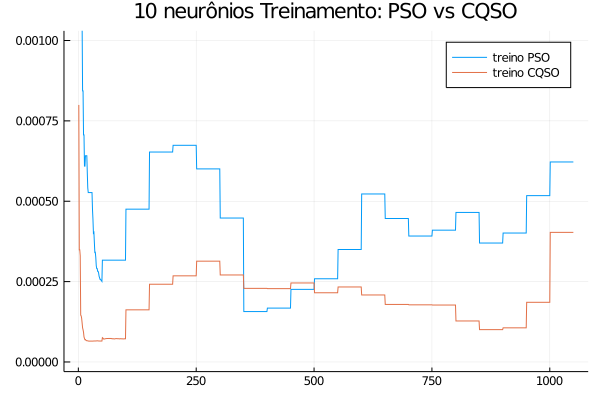

In [106]:
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001], title = "10 neurônios Treinamento: PSO vs CQSO")
plot!(mse_treino_cqso, label= "treino CQSO")

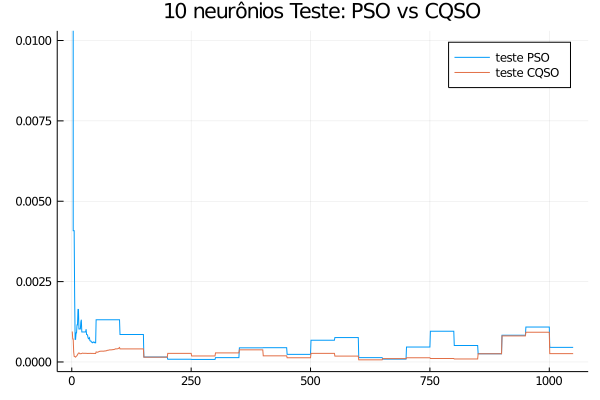

In [107]:
plot(mse_teste_pso, label= "teste PSO", ylims = [0.0, 0.01], title = "10 neurônios Teste: PSO vs CQSO")
plot!(mse_teste_cqso, label= "teste CQSO")

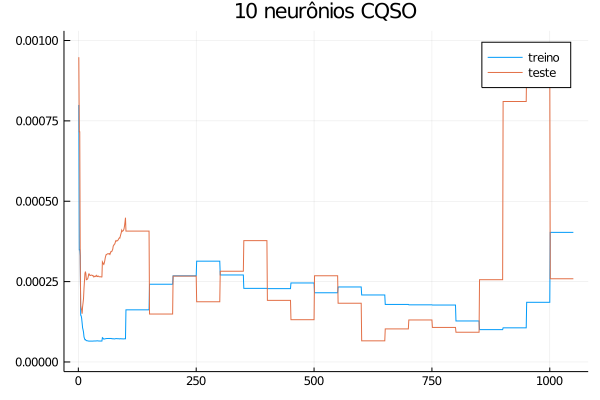

In [108]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.001], title = "10 neurônios CQSO")
plot!(mse_teste_cqso, label = "teste")

### Testando com 12 neuronios

In [109]:
n_h = 12
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [110]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

  9.132791 seconds (19.91 M allocations: 3.959 GiB, 7.97% gc time)


([2.4293119349498307, 0.4409464798943673, 0.005563957302464477, 0.002093278787642077, 0.002093278787642077, 0.002093278787642077, 0.002093278787642077, 0.002093278787642077, 0.00222655768513119, 0.0016111156898558714  …  0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586, 0.00038302241794113586], [2.4107212654438097, 0.37567048192135777, 0.004225308905834298, 0.0012473781974297177, 0.0012473781974297177, 0.0012473781974297177, 0.0012473781974297177, 0.0012473781974297177, 0.0017636112968257135, 0.0015338028510808593  …  0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105, 0.0006785922514671105], [2.510150655473755, 0.5932366799490326, 0.001667729271278073, 0.001535287207707

In [111]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

Quantidade total de iter: (1050,)
 33.922344 seconds (58.47 M allocations: 24.381 GiB, 13.04% gc time)


([0.0008169632086830181, 0.00035292563411655074, 0.0003497462165380272, 0.0003361652351760663, 0.00021174684917157162, 0.00013565133173014596, 0.00013565133173014596, 0.0001169140417880888, 0.00011527182009946196, 0.00010799239004841293  …  0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698, 0.0002895084128397698], [0.000753106053037009, 0.00019791732355623615, 0.00019267696010629497, 0.00017016737999939305, 0.00022034616810185962, 6.419726742314607e-5, 6.419726742314607e-5, 7.710047567442956e-5, 7.21071589120695e-5, 5.888804828831085e-5  …  0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893, 0.0005639614617282893], [0.0006378548448235078, 0.0007148623022181293, 0.00071697309151793

In [112]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

Média mse treino PSO: 0.0030686246920150345
Média mse teste PSO: 0.0033411904708187043
Média mse treino CQSO: 0.0001800217759897941
Média mse teste CQSO: 0.00026649435253740307


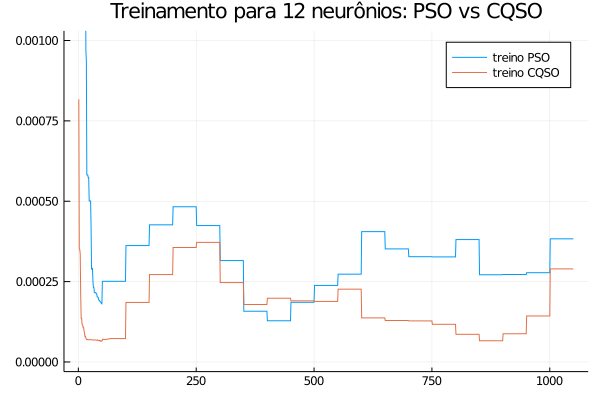

In [113]:
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001], title = "Treinamento para 12 neurônios: PSO vs CQSO")
plot!(mse_treino_cqso, label= "treino CQSO")

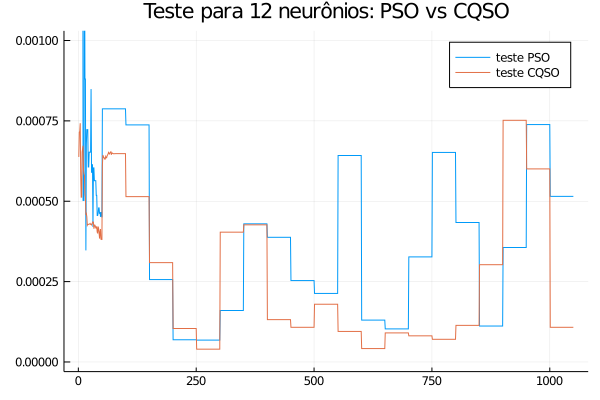

In [114]:
plot(mse_teste_pso, label= "teste PSO", ylims = [0.0, 0.001], title = "Teste para 12 neurônios: PSO vs CQSO")
plot!(mse_teste_cqso, label= "teste CQSO")

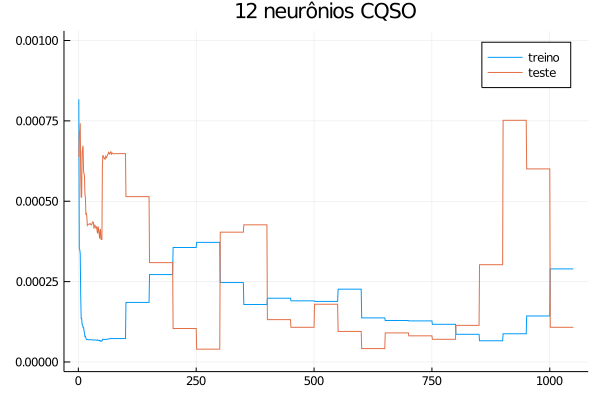

In [115]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.001], title = "12 neurônios CQSO")
plot!(mse_teste_cqso, label = "teste")

### Testando com 14 neuronios

In [229]:
n_h = 14
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [230]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

 21.199278 seconds (23.19 M allocations: 5.095 GiB, 5.69% gc time)


([2.1678224140064613, 0.043495351609131545, 0.024760826466426012, 0.02746527265920352, 0.02493373073727532, 0.008472610651886174, 0.006975922211672129, 0.00322744378376462, 0.0024722487305547996, 0.0024722487305547996  …  0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348, 0.0006749155959346348], [2.121947459932476, 0.008638371528642887, 0.010431711877120088, 0.019122080732779607, 0.021908882939614117, 0.005664635547326128, 0.006667469359811243, 0.003268118654773355, 0.0015403349124296086, 0.0015403349124296086  …  0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393, 0.0013747660972389393], [2.332598567633179, 0.07183452954147874, 0.017339271352056655, 0.0099902002398629, 0.01439306

In [231]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

Dimensao: 169
190.145803 seconds (175.47 M allocations: 105.711 GiB, 11.92% gc time)


([0.0014520350912538929, 0.0003526043867451684, 0.0002893174254927748, 0.0002893174254927748, 0.00027316364270301466, 0.0002275367853228432, 0.00021788311663661065, 0.0002065148450430732, 0.00019531780022610587, 0.0001945313221467347  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.001288478630094022, 0.00019754441776690103, 0.00019617316912577757, 0.00019617316912577757, 0.00019421169287384582, 0.00014644444028173294, 0.00012296543916307038, 0.00012918720812043146, 0.00011701009303102972, 0.0001477353860992787  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0013179428994750581, 0.0007111578164144649, 0.0005215780656635923, 0.0005215780656635923, 0.0004929048598094959, 0.00030271409096972474, 0.0004000437156699907, 0.00034257144588301823, 0.0003454512400396026, 0.00021533101648814129  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [232]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

Média mse treino PSO: 0.0025942008472124253
Média mse teste PSO: 0.0028328348170794295
Média mse treino CQSO: 0.00015430239952862813
Média mse teste CQSO: 0.0002132433783891064


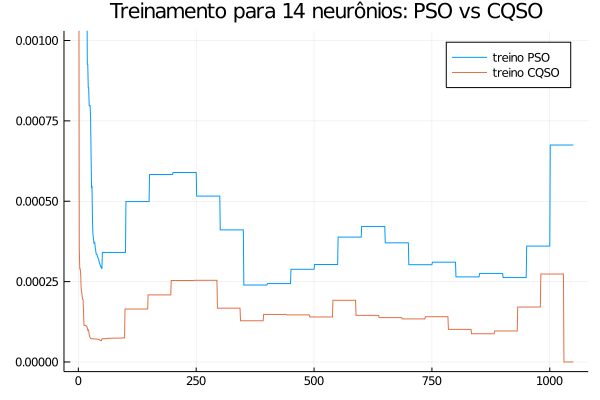

In [233]:
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001], title = "Treinamento para 14 neurônios: PSO vs CQSO")
plot!(mse_treino_cqso, label= "treino CQSO")

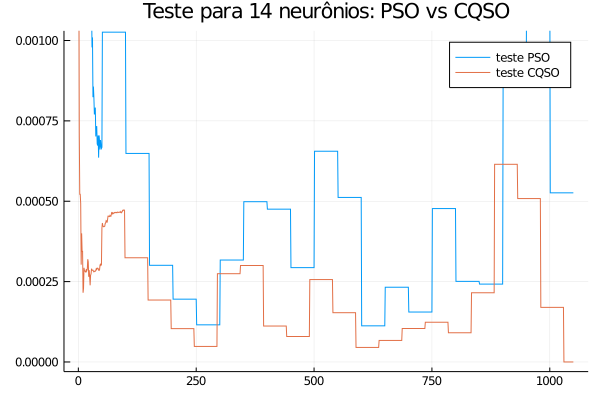

In [234]:
plot(mse_teste_pso, label= "teste PSO", ylims = [0.0, 0.001], title = "Teste para 14 neurônios: PSO vs CQSO")
plot!(mse_teste_cqso, label= "teste CQSO")

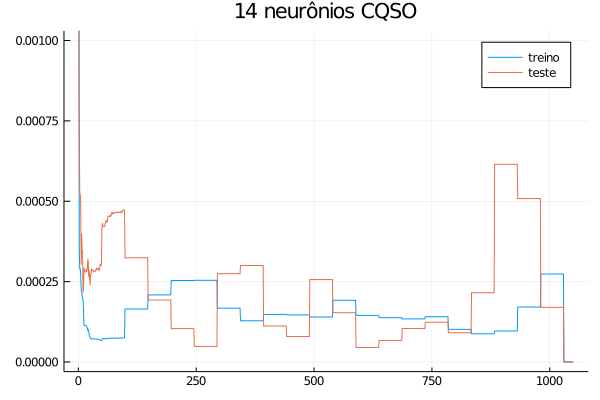

In [235]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.001], title = "14 neurônios CQSO")
plot!(mse_teste_cqso, label = "teste")

### Testando com 15 neuronios

In [116]:
n_h = 15
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [117]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

 13.348006 seconds (24.82 M allocations: 5.739 GiB, 8.56% gc time)


([2.1021363200728085, 0.035571132690257544, 0.0161453523424787, 0.018347365845564727, 0.018347365845564727, 0.014885236739876446, 0.007615350793659195, 0.006230629801977003, 0.006230629801977003, 0.005989912204744095  …  0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364, 0.002470309322525364], [2.0566242725691257, 0.00588411636568494, 0.005380513038780798, 0.012515008199720214, 0.012515008199720214, 0.013023183234283144, 0.0034242178685882966, 0.0035716226135644523, 0.0035716226135644523, 0.003966769820365817  …  0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049, 0.005325288557141049], [2.2722006768513165, 0.055358783820494945, 0.01949122749064418, 0.013047413437454263, 0.013047413437454263, 0.007

In [ ]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

In [ ]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

In [ ]:
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001], title = "Treinamento para 15 neurônios: PSO vs CQSO")
plot!(mse_treino_cqso, label= "treino CQSO")

In [ ]:
plot(mse_teste_pso, label= "teste PSO", ylims = [0.0, 0.001], title = "Teste para 15 neurônios: PSO vs CQSO")
plot!(mse_teste_cqso, label= "teste CQSO")

In [ ]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.001], title = "15 neurônios CQSO")
plot!(mse_teste_cqso, label = "teste")

#### Função n_model_cqso para preparar o CQSO para rodar 

In [52]:
function n_model_cqso(X, y, n_h::Int64, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)
    
    n_in = size(X)[2]
    
    parametros = init_params(n_in, n_h)
    
    println("Neuronios: ", n_h)
#     A2 = forward_prop(X', parametros)

#     best_cost = compute_cost(A2, y')
    
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    
    dim_list = [prod(size(W1)), prod(size(b1)), prod(size(W2)), prod(size(b2))]
    
    println("dim list: ", dim_list)
    
    qtd_particulas_dim = convert(Int64,(size(W1)[2] + 1) * size(W1)[1] + (size(W1)[1] + 1)* size(W2)[1])
    
    println("qtd particulas dim: ", qtd_particulas_dim)

    mse_treino, mse_val, mse_teste = CQSO(X, y, parametros, qtd_particulas_dim, dim_list, num_iteracoes, -1.0, 1.0, perc_treino, perc_val, neutral_p, rcloud)    
        
    return mse_treino, mse_val, mse_teste
end

n_model_cqso (generic function with 1 method)

#### Função Cenários execucoes CQSO

In [53]:
# Criando cenários
function cenarios_execucoes_cqso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64, netural_p::Int64, rcloud::Float64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    neuronios = 2:25
    
    mse_treino = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
        
        # Neuronios
        for (j,z) in zip(neuronios, eachindex(neuronios))
            
            mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = n_model_cqso(X_I, y_I, j, f, perc_treino, perc_val, neutral_p, rcloud)

            # salvar lista com os mse de treino para todas as iterações
            mse_treino[execucao, z,:] = mse_treino_lista_temp
            # salvar lista com os mse de validacao para todas as iteracoes
            mse_val[execucao, z,:] = mse_val_lista_temp
            # salvar lista com os mse de teste para todas as iterações
            mse_teste[execucao, z,:] = mse_teste_lista_temp

        end
    end
    return mse_treino, mse_val, mse_teste
end
            

cenarios_execucoes_cqso (generic function with 1 method)

### Teste cenários CQSO SUNSPOT - Cenário 1

In [88]:
@time sunspot_mse_treino_1_cqso, sunspot_mse_val_1_cqso, sunspot_mse_teste_1_cqso = cenarios_execucoes_cqso(X, y, w, s, f, 0.54, 0.24, 3, 25, 0.2)

Quantidade de iterações: 300
Execução: 1


LoadError: UndefVarError: neutral_p not defined